In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import json
from ctypes import *
%matplotlib inline

In [23]:
board_size = 30
device = torch.device('cuda')
batch_size = 32
# ctypes init
bfs = CDLL("./bfs.so")
a = c_int * (900 * 450 * 2)

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [67]:
# mlp = MLP()
mlp = torch.load("model")
mlp.train()
losses = []
train = []
running_loss = 0.1
mlp.to(device)

MLP(
  (layers): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [68]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)

In [171]:
dataset = []
raw_dataset = a()
length = bfs.gameSim(raw_dataset)
for row_index in range(length):
    temp = []
    for col_index in range(row_index):
        t = (raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2], raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2 + 1])
        temp.append(t)
    dataset.append(temp)
count = 0


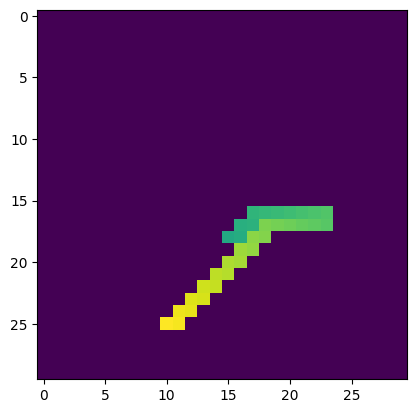

In [205]:
board = np.zeros((30, 30))
for i, val in enumerate(dataset[count]):
    board[val] = 1 - i/length 
plt.imshow(board)
count += 1

In [ ]:
while True:
    dataset = []
    raw_dataset = a()
    length = bfs.gameSim(raw_dataset)
    for row_index in range(length):
        temp = []
        for col_index in range(row_index):
            t = (raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2], raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2 + 1])
            temp.append(t)
        dataset.append(temp)
    
    for sample in dataset:
        rand = int(np.random.rand() * len(train))
        sample.append(length/900)
        train.append(sample)
        if len(train) > 10000:
            train.remove(train[rand])
    
    batch = torch.zeros(1, 1, 30, 30, device=device)
    labels = torch.zeros(batch_size, 1, device=device)
    
    for i in range(batch_size):
        rand = int(np.random.rand() * len(train))
        sample = train[rand][:len(train[rand]) - 1]
        labels[i] = train[rand][len(train[rand]) - 1:][0]
        board = torch.zeros(board_size, board_size, device=device)
        for number, tupl in enumerate(sample):
            board[tupl] = ((number + 1)/len(sample))
        batch = torch.cat([batch, board.view(1, 1, 30, 30)], dim=0)
        
    batch = torch.cat((batch[:0], batch[0+1:])) # remove first row
    optimizer.zero_grad()
    outputs = mlp(batch) #(length, moves)
    loss = loss_function(outputs, labels)
    running_loss = (running_loss * 0.9) + (loss.item() * 0.1)
    print(running_loss)
    losses.append(running_loss)
    loss.backward()
    optimizer.step()
        


0.09013220852706583
0.08123513184161858
0.07325172542859802
0.06603350096434822
0.059562915452763925
0.05369748908133029
0.04842513822565498
0.04374741243317743
0.039494406319365086
0.03569584730196462
0.03222771431050569
0.02913076653834614
0.026355986374115348
0.023847520986474666
0.021564275423256708
0.01951939257195725
0.017715568423948145
0.01608869683924522
0.0146293383286882
0.01329592168690907
0.01212159846534637
0.011032525888997084
0.010052421082967014
0.009181952806484841
0.008395773269129225
0.00766082623833486
0.007032036359558867
0.006426007200435132
0.005866377449770568
0.005388614340564428
0.004945702472965406
0.004515296905166346
0.004196846993984078
0.003923110018235113
0.0036269664599645874
0.0034337692885457343
0.0032039224208988727
0.0029813307139588577
0.002782881055845009
0.002635223630620408
0.002486983262944252
0.0023340528311767707
0.002204222364662307
0.002198525558319584
0.0020813624805683453
0.0019674602271165307
0.001865822239425408
0.001793510268589819
0.

0.0011137868694191236
0.0011010722515597993
0.00118890404232875
0.001176873019872178
0.001223091948476198
0.0012466477758333945
0.0012288126359116314
0.0011712335226444553
0.0011711489195383922
0.0011632854764691595
0.0011697547206683402
0.0011833745270620386
0.0011681211305283549
0.001201373117055569
0.0012410531340265934
0.001213708452628523
0.0011883061611620812
0.001204329447318753
0.001209408564227498
0.001201275679695764
0.0011518655477548321
0.001138598476838441
0.0011468894544911722
0.0010955745073152191
0.0011100539963983839
0.0011508657830284546
0.0011486617755548517
0.0011364774625180387
0.001126767085106214
0.0011436036910550656
0.0011289311590138252
0.0011178874798723915
0.0011426872457363183
0.0011512222036240674
0.0011131297257950016
0.0011403319872090318
0.0011574244551549046
0.0011250763815438469
0.0010999848804924537
0.0011925464214358017
0.001195376713556643
0.0012116587492667994
0.0012378071276032952
0.0012433491457790758
0.0012688308318070138
0.0012893592668908743


0.0012381328990577654
0.0012200202277394233
0.001176126232775712
0.0011816225562164165
0.0012144245700093188
0.0012096874952511856
0.0011744583799586626
0.001171578769383961
0.001183931983372391
0.0012097134334839769
0.0011834395748821546
0.0011471166261052474
0.0011366401925771282
0.001127129574072109
0.001114205746700686
0.0011776053157600656
0.001194289009297898
0.0011839221029579735
0.0011954627097338524
0.0011703365116158952
0.0012268456836311368
0.0012070392094531669
0.0012001312423106146
0.0011688851036524277
0.0011457716554104985
0.0011228445532742621
0.001145088386564566
0.0011351815783865273
0.0011165310695703645
0.0011235465495603519
0.0011872876592226836
0.0011745007011516105
0.0011882960774278533
0.0012077899676435494
0.0012166328659093354
0.0011981349981593466
0.0012273633549824993
0.0012017018215178526
0.0011910559657650362
0.0011729046652558897
0.001160614509307753
0.001147520221924851
0.0011279461421536533
0.0011648458458900866
0.0011469732578102128
0.00111614445771865

0.0013164916376190489
0.0013443776700012779
0.0013348975483131018
0.0013407485285223968
0.0013078546905767722
0.0012537186060921969
0.0012605748303228575
0.0012868978090951407
0.0013124167227702942
0.0012864090531877522
0.0013158179427142601
0.0012399035455433127
0.0012351440988650258
0.001249337524507523
0.0012449799404672507
0.0012667673559939913
0.0012252839466256843
0.001227339946470226
0.001228923825092523
0.0012612413555017788
0.0012548276308967184
0.0012482400804610708
0.0012230217668281489
0.0011825547767199422
0.0011624777066909383
0.0011238111961423406
0.0011766881218363986
0.001190130273064388
0.0012578235335443137
0.0012791459557229626
0.0012881380603594495
0.001328165400256179
0.0013472751858646832
0.0012880740165247169
0.0012751332712874098
0.001276686514820631
0.0012876131910735153
0.0012507083571988745
0.0012265015374642674
0.001190932541553041
0.0012006292319719737
0.0012397301516838145
0.0012367601649864559
0.0012131352246392408
0.0012402801550706005
0.001223658522012

0.0013249898456607957
0.0013473751137919455
0.0014504274689272551
0.0014234016392930305
0.0014143229557324014
0.0014382957380189207
0.001418669903904829
0.001416970791058064
0.0014195353226464872
0.0013497253548482256
0.001317241853543001
0.001315976938628743
0.001283016317135325
0.0012729513249587097
0.0013010990990064513
0.00133783568655583
0.001359938741443003
0.001416482049309413
0.0013859846208802169
0.0013520764088014935
0.0013398522538472868
0.0013631693205263906
0.001348666121604445
0.0013593009316741546
0.001339373316677879
0.001309295832887266
0.0012795911065153545
0.0012703948559384583
0.0012761138084661401
0.001284521402791718
0.0012873190395539219
0.001307951288056095
0.0012871784754716334
0.0013113306860065143
0.0013591497949267041
0.0013456805557053935
0.001304758673034607
0.0012681903193868685
0.0012801383277828238
0.0012634739109699197
0.0013289441271378934
0.0013639860106263466
0.0013591956759471215
0.0013144173436685817
0.001406422083712317
0.001410757521755276
0.001

0.001229782385231871
0.0012656270557062197
0.001228606615185711
0.0011851932873680948
0.0011639778194521154
0.001181109948324646
0.0012329078025489918
0.0012506482707890752
0.0012695561581417515
0.0012668261913789446
0.0012336631260160178
0.0013172148499796007
0.0013137384043590023
0.0013819265491326863
0.0013876733487935555
0.0013343676250752085
0.0013139169149765022
0.0013275914503114207
0.0013175152417698606
0.001312437045351783
0.0013287250113348241
0.0013544050678969987
0.0013101284799489292
0.0013435187464218956
0.0013198043847690482
0.0014128180227080398
0.00137122633924181
0.0014371717242085463
0.0014122297053203161
0.001469267848625646
0.00151782220299828
0.0015131129652071413
0.0014849631885640398
0.0015003804461056808
0.001459924050798549
0.0014655340107952361
0.001436673019264621
0.0013740998912855082
0.00138271501871235
0.0013643771425243035
0.001403528460277392
0.001378158701655215
0.001323665689461928
0.001262414900671841


In [45]:
len(train)

1000

In [66]:
# torch.save(mlp, "model")

In [26]:
xs = []
ys = []

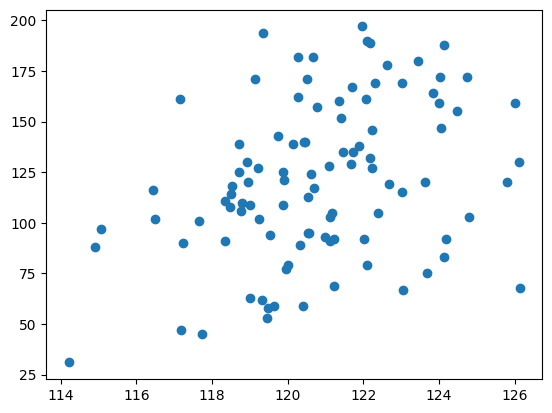

In [27]:
for epoch in range(100):
    snake = [(14, 14)]
    guesses = []
    mlp.eval()
    while True:
        while True:
            apple = (int(np.random.rand(1) * board_size), int(np.random.rand(1) * board_size))
            if apple not in snake:
                break
        pathington = BFS(snake[0], apple, snake, 1)
        if len(pathington) == 0:
#             print(len(snake))
            break
        lowest_index = 0
        lowest_score = -10000
        for i, path1 in enumerate(pathington):
            board = torch.zeros(board_size, board_size, device=device)
            for number, point in enumerate(path1):
                board[point] = ((number + 1)/len(path1))
            board = board.view(-1, 900)
            score = mlp(board.view(1, 1, 30, 30))
            if score > lowest_score:
                lowest_score = score
                lowest_index = i
#         print(lowest_score.item() * 900)
        guesses.append(lowest_score.item() * 900)
        path = pathington[lowest_index]
        path = path + snake
        snake.append((0, 0))
        for i, piece in enumerate(snake):
            snake[i] = path[i]
#     print(sum(guesses)/len(guesses))
    xs.append(sum(guesses)/len(guesses))
    ys.append(len(snake))
    mlp.train()
plt.scatter(xs, ys)

In [109]:
board = torch.zeros(board_size, board_size)
board[(14, 14)] = 1
innington = board.view(1, 1, 30, 30)
mlp.eval()
logits = mlp(innington)
length = logits[0][0].item() * 900
print(length)
mlp.train()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

In [346]:
# best loss:   0.00207378133200109
# 0.003948253579437733
# 0.0002190066152252257
# 0.00013125113036949188
# 0.0016721078427508473
# 0.0006189789273776114
# 4.9065616622101516e-05
# 7.81641501816921e-05
# 0.009134437888860703
# 2.2606200218433514e-05

# this is probably from just blindly predicting 100-130

114/900

0.12666666666666668

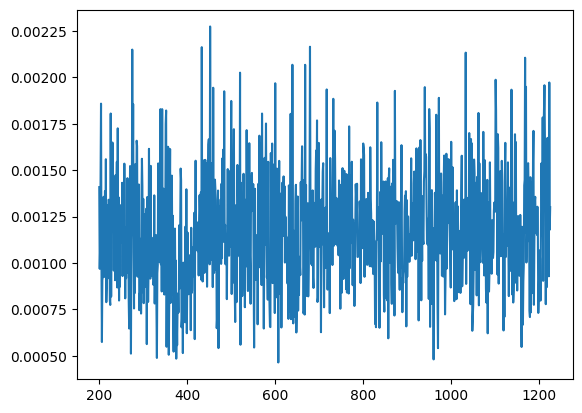

In [70]:
smooth = 1
x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[200:], y[200:])
